In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import arviz as az
import pymc3 as pm
import theano.tensor as tt
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [2]:
# Read the data
howell1 = pd.read_csv('../Data/Howell1.csv',sep=';')

# Normalize the age column
howell1['age'] = StandardScaler().fit_transform(howell1['age'].values.reshape(-1,1))

# Divide dataframe into two equal
d1, d2 = train_test_split(howell1, test_size=0.5, random_state=42)

In [3]:
d1.describe()

,height,weight,age,male
count,272.000000,272.000000,272.000000,272.000000
mean,139.846248,36.518423,-0.007330,0.459559
std,26.206521,14.259042,0.981193,0.499280
min,55.880000,4.847764,-1.415702,0.000000
25%,130.340100,24.408919,-0.788525,0.000000
50%,149.225000,41.276872,-0.161348,0.000000
75%,157.638750,47.520849,0.610562,1.000000
max,172.999400,58.825212,2.829802,1.000000


## Polynomial models

In [4]:
from sklearn.preprocessing import PolynomialFeatures
import pickle

def pickle_model(output_path: str, model, trace):
    """Pickles PyMC3 model and trace"""
    with open(output_path, "wb") as buff:
        pickle.dump({"model": model, "trace": trace}, buff)
        
def sample_polynomial_regressions(d1, xcol, ycol, degree=1):

    yval = d1[ycol].values
    # Polynomial features
    polynomial_features= PolynomialFeatures(degree=degree, include_bias=False)
    xval = polynomial_features.fit_transform(d1[xcol].values.reshape(-1,1))
    
    with pm.Model() as model_1:
        a = pm.Normal('a', mu=10, sigma=10)
        b = pm.Normal('b', mu=0, sigma=1,shape=(degree))
        sigma = pm.Uniform('sigma', lower=0, upper=10)
        mu = pm.Deterministic('mu', a + tt.dot(xval,b))
        h = pm.Normal('h', mu=mu, sigma=sigma, observed=yval)
        trace_1 = pm.sample(cores=2)
    
    model_1.name = 'M%d' % degree
    pickle_model('polynomial_model_degree_%d.pkl' % degree, model_1, trace_1)
    return model_1,trace_1

In [5]:
model1,trace1 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=1)
model2,trace2 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=2)
model3,trace3 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=3)
model4,trace4 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=4)
model5,trace5 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=5)
model6,trace6 = sample_polynomial_regressions(d1, xcol='age', ycol='height',degree=6)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1012.01draws/s]
The acceptance probability does not match the target. It is 0.8873827940406847, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:09<00:00, 215.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:13<00:00, 145.54draws/s]
The acceptance probability does not match the target. It is 0.9010408818363714, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-ass

In [11]:
models = [model1, model2, model3, model4, model5, model6]
traces = [trace1, trace2, trace3, trace4, trace5, trace6]

model_dict = dict(zip(['M1','M2','M3','M4','M5','M6'], traces))
comp = pm.compare(model_dict)
comp

/home/amit/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
M5,0,1968.15,5.79159,0,0.762926,60.8271,0,True,deviance
M6,1,1973.44,4.86808,5.29505,0.237074,100.033,6.86243,True,deviance
M4,2,2029.06,5.59141,60.9139,2.35341e-08,35.3734,14.1139,True,deviance
M3,3,2132.16,6.30816,164.015,2.54447e-21,25.3536,28.3554,True,deviance
M2,4,2376.42,7.47997,408.278,4.14275e-61,27.3294,57.6344,True,deviance
M1,5,2861.98,8.05531,893.831,1.48594e-143,25.3744,96.7082,False,deviance


## Averaged Model vs M5: Posterior Predictive Check

In [73]:
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, models,
                        weights=comp.weight.sort_index(ascending=True),
                        progressbar=False)

In [74]:
ppc_5 = pm.sample_posterior_predictive(trace5, 1000, model5,
                     progressbar=False)

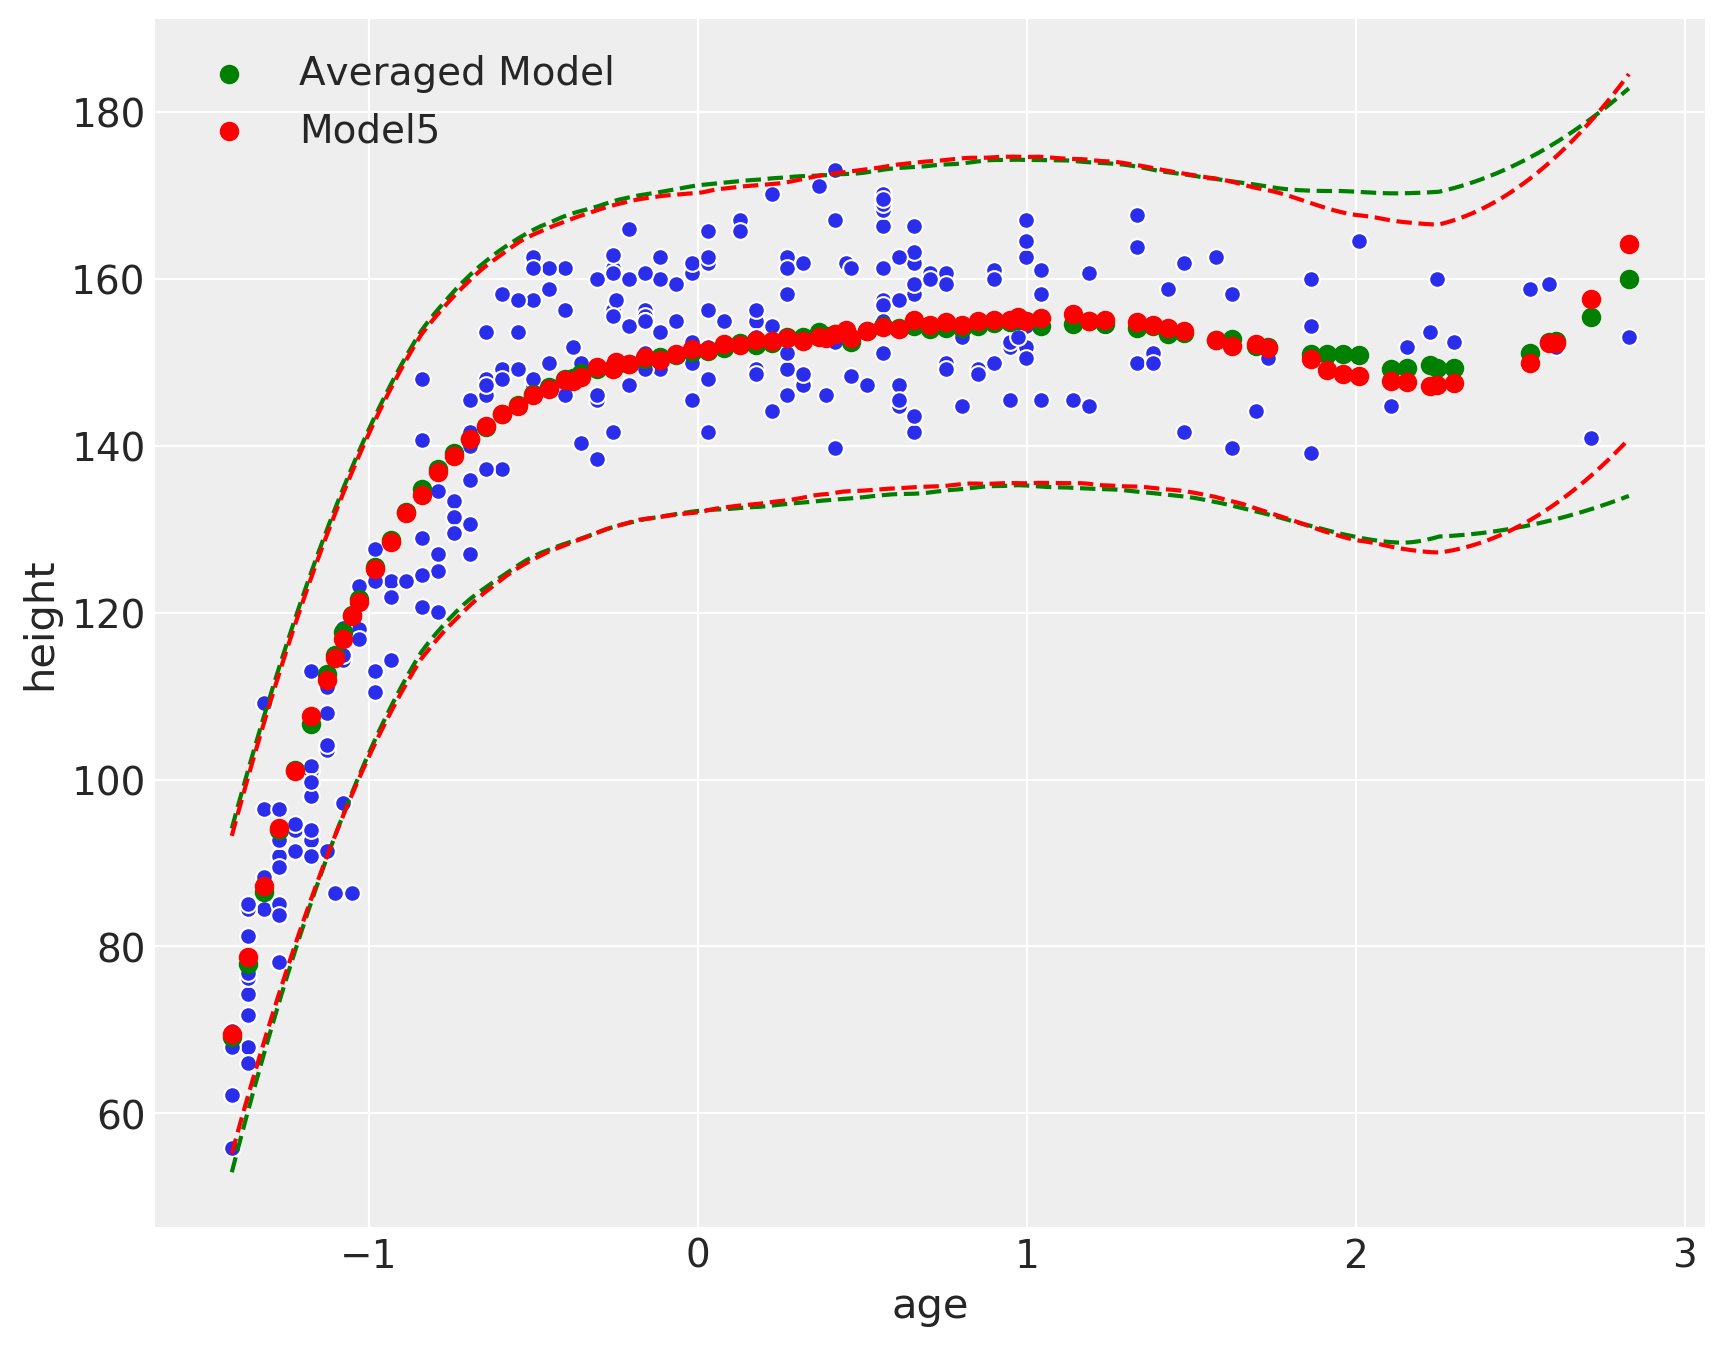

In [82]:
# To plot hpd: arrange x in ascending order and remove duplicates
fig,ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x='age',y='height',data=d1)

xdata = d1['age'].values
ydata = d1['height'].values
sorted_ind = np.argsort(xdata)

xdata = xdata[sorted_ind]
ydata = ydata[sorted_ind]
ydata_avg = ppc_w['h'][:,sorted_ind]
ydata_5 = ppc_5['h'][:,sorted_ind]

tmp,unique_ind = np.unique(xdata, return_index=True)

xdata = xdata[unique_ind]
ydata = ydata[unique_ind]
ydata_avg = ydata_avg[:,unique_ind]
ydata_5 = ydata_5[:,unique_ind]

ax.scatter(xdata,ydata_avg.mean(0),label='Averaged Model',c='g')
ax.scatter(xdata,ydata_5.mean(0),label='Model5',c='r')
az.plot_hpd(xdata,ydata_avg,
                fill_kwargs={'alpha': 0},
                plot_kwargs={'alpha':1, 'color':'g', 'ls':'--'},ax=ax, credible_interval=.97)
az.plot_hpd(xdata,ydata_5,
                fill_kwargs={'alpha': 0},
                plot_kwargs={'alpha':1, 'color':'r', 'ls':'--'},ax=ax, credible_interval=.97)
ax.legend()